# Bookworm Recommender System Project

> Meghdad Sanii <br>
> University of San Diego <br>
> AAI 541: Capstone Project <br>
> December 12, 2022 <br>


## Project Contents<br>

*   Load the dataset
*   EDA
*   Data Preprocessing
*   Save/Load the clean data
*   Popularity-based recommender
*   Content-based recommender
	*   Count Vectorizer
	*   TF-IDF Vectorizer
	*   Doc2Vec
	*   Bert
	*   Performance Metrics
	*   Prepare the test dataset
	*   Outputs/Testing	







# Load Libraries

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval

# Tensorflow
import tensorflow as tf

# Sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity


**Google Drive Mounting** (each of us need to mount it to our own Google drive)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# google drive where you stored the csv files)
folderpath = '/content/drive/MyDrive/BookDataset/'


Mounted at /content/drive




# Load the datasets

In [ ]:
# Load the csv files
books = pd.read_csv(folderpath + "Books.csv")
ratings = pd.read_csv(folderpath + "Ratings.csv")
users = pd.read_csv(folderpath + "Users.csv")


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
books.head(5)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
ratings.head(5)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
users.head(5)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
print("Books Shape: " , books.shape )
print("Ratings Shape: " , ratings.shape )
print("Users Shape: " , users.shape )


Books Shape:  (271360, 8)
Ratings Shape:  (1149780, 3)
Users Shape:  (278858, 3)


# EDA

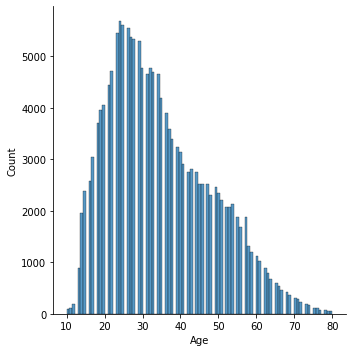

In [ ]:
# Display the distribution of users' age 
users_age = users[(users['Age'] >= 10) & (users['Age'] <= 80)]
sns.displot(users_age['Age'])


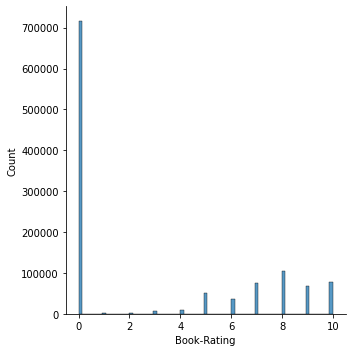

In [ ]:
# Display the distribution of rating scores across all ratings
sns.displot(ratings['Book-Rating'])


In [ ]:
# Count how many books each user has rated
ratings_per_user = ratings.groupby(['User-ID'], 
                                   as_index = False)['ISBN'].count()
print("the median number of ratings per user: ", 
      ratings_per_user["ISBN"].median())
print("the average number of ratings per user: ", 
      ratings_per_user["ISBN"].mean())

ratings_per_user.head()


the median number of ratings per user:  1.0
the average number of ratings per user:  10.920851419507423


,User-ID,ISBN
0,2,1
1,7,1
2,8,18
3,9,3
4,10,2


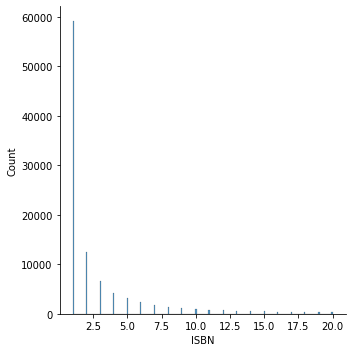

In [ ]:
# Display the distribution of number of ratings by a user
users_rating_dist = ratings_per_user[(ratings_per_user['ISBN'] >= 0) & 
                                     (ratings_per_user['ISBN'] <= 20)] 
sns.displot(users_rating_dist.ISBN) 


In [ ]:
# Checking number of authors compared to ISBNs as a possible feature
author_list = books.groupby(['Book-Author'], as_index = False)['ISBN'].count()
shared_author_list = author_list[author_list['ISBN'] > 1]
shared_author_list = shared_author_list.rename(columns={"ISBN": "ISBN_Count"})
shared_author_list


,Book-Author,ISBN_Count
7,2000,2
13,A &amp; E Television Network,2
14,A A Milne,5
17,A B Guthrie,2
22,A E Hartink,2
...,...,...
101997,selected Karen Sullivan,2
102005,tk,6
102009,unknown,2
102017,x x,4


In [ ]:
# Authors with only one ISBN
author_with_singleISBN = author_list[author_list['ISBN'] == 1]
author_with_singleISBN.shape


(68393, 2)

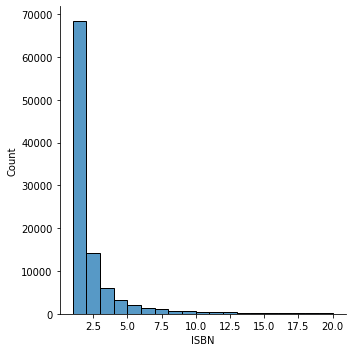

In [ ]:
# Display the distribution of shared authors' frequencies
sns.displot(author_list, x = "ISBN", bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
                                             12, 13, 14, 15, 16, 17, 18, 19, 
                                             20])


In [ ]:
# Checking number of publishers compared to ISBNs as a possible feature
publisher_list = books.groupby(['Publisher'], as_index = False)['ISBN'].count()
shared_publisher_list = publisher_list[publisher_list['ISBN'] > 1]
shared_publisher_list = shared_publisher_list.rename(columns = 
                                                     {"ISBN": "ISBN_Count"})
shared_publisher_list


,Publisher,ISBN_Count
5,10-18,41
6,10/18,12
7,10/18 UGE,2
10,101 Productions,3
16,1stBooks Library,129
...,...,...
16777,pocket books,2
16780,s.n.],3
16781,scholastic,16
16791,toExcel,3


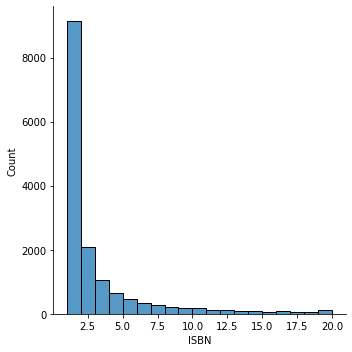

In [ ]:
# Display the distribution of shared publishers' frequencies
sns.displot(publisher_list, x = "ISBN", bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                                                11,12, 13, 14, 15, 16, 17, 18,
                                                19, 20])


**Check for Null values**

In [ ]:
# Null in Books columns
print(books.isnull().sum())


ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


In [ ]:
# Null in Ratings columns
print(ratings.isnull().sum())


User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [ ]:
# Null in Users columns
print(users.isnull().sum())


User-ID          0
Location         0
Age         110762
dtype: int64


# Preprocessing

* Add the Number of Ratings and Average Ratings for each Book

In [ ]:
books.shape


(271360, 8)

In [ ]:
# Get the number of ratings per book
books_rating_count = ratings.groupby("ISBN").count()["Book-Rating"].reset_index()
books_rating_count.rename(columns = 
                          {"Book-Rating":"NumberOfRatings"}, inplace = True)
books_rating_count


,ISBN,NumberOfRatings
0,0330299891,2
1,0375404120,2
2,0586045007,1
3,9022906116,2
4,9032803328,1
...,...,...
340551,cn113107,1
340552,ooo7156103,1
340553,§423350229,1
340554,´3499128624,1


In [ ]:
# Get the average rating per book
book_rating_average = ratings.groupby("ISBN")["Book-Rating"].mean().reset_index()
book_rating_average.rename(columns = 
                           {"Book-Rating":"AverageRatings"}, inplace = True)
book_rating_average


,ISBN,AverageRatings
0,0330299891,3.0
1,0375404120,1.5
2,0586045007,0.0
3,9022906116,3.5
4,9032803328,0.0
...,...,...
340551,cn113107,0.0
340552,ooo7156103,7.0
340553,§423350229,0.0
340554,´3499128624,8.0


In [ ]:
# Merge rating count to Books df
books = books.merge(books_rating_count, on = "ISBN", how='left')

# Merge rating average to Books df
books = books.merge(book_rating_average, on = "ISBN", how = 'left')


In [ ]:
books.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,NumberOfRatings,AverageRatings
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,1.0,0.000000
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,14.0,4.928571
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,3.0,5.000000
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,11.0,4.272727
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,1.0,0.000000


In [ ]:
# Checking the ISBNs in ratings table exist in books table.
books_ISBNs = list(books['ISBN'].unique())
ver_rat = ratings[ratings['ISBN'].isin(books_ISBNs)]
ver_rat.head()


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


* Merge the Tables into one final dataframe

In [ ]:
# Merge the tables
ratings_df = ratings.merge(books, on = "ISBN")
ratings_df = ratings_df.merge(users, on = "User-ID")
ratings_df.shape


(1031136, 14)

* Clean the dataframe

In [ ]:
# Drop unnecessary columns
ratings_df.drop(columns = ["Location", "Age", "Image-URL-S", "Image-URL-M"], 
                axis = 1, inplace=True) 


In [ ]:
# drop the rows with null values
books.dropna(inplace = True)

# drop the rows with null values
ratings_df.dropna(inplace = True)

# drop rows with publishing year "0"
ratings_df['Year-Of-Publication'] = pd.to_numeric(ratings_df['Year-Of-Publication'], 
                                                  errors = 'coerce')
ratings_df = ratings_df[ratings_df['Year-Of-Publication'] != 0]

# drop rows where author is a number
ratings_df = ratings_df[ratings_df["Book-Author"] != 
              ratings_df["Book-Author"].astype(str).str.contains(r'\d')]

# Change the column type to integer for NumberOfRatings and UserID
ratings_df['NumberOfRatings'] = ratings_df['NumberOfRatings'].astype(int)
ratings_df['User-ID'] = ratings_df['User-ID'].astype(int)

# Round the decimal values to 2 for Average Rating
ratings_df['AverageRatings'] = ratings_df['AverageRatings'].round(decimals = 2)

# drop the rows with null values
ratings_df.dropna(inplace = True)


In [ ]:
# Search for any books based on User-ID (used for testing purposes)
search_record2 = ratings_df[ratings_df['User-ID'] == 2313]
search_record2.head(10)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,NumberOfRatings,AverageRatings
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,60,2.93
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,http://images.amazon.com/images/P/0812533550.0...,23,5.35
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,http://images.amazon.com/images/P/0679745580.0...,55,2.84
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,http://images.amazon.com/images/P/0060173289.0...,130,3.45
5,2313,0385482388,5,The Mistress of Spices,Chitra Banerjee Divakaruni,1998,Anchor Books/Doubleday,http://images.amazon.com/images/P/0385482388.0...,80,3.82
6,2313,0399146431,5,The Bonesetter's Daughter,Amy Tan,2001,Putnam Publishing Group,http://images.amazon.com/images/P/0399146431.0...,117,3.36
7,2313,0345348036,9,The Princess Bride: S Morgenstern's Classic Ta...,WILLIAM GOLDMAN,1987,Del Rey,http://images.amazon.com/images/P/0345348036.0...,169,3.87
8,2313,0553278223,7,The Martian Chronicles,RAY BRADBURY,1984,Spectra,http://images.amazon.com/images/P/0553278223.0...,65,3.97
9,2313,0449912558,0,The Sparrow,MARY DORIA RUSSELL,1997,Fawcett Books,http://images.amazon.com/images/P/0449912558.0...,106,3.89
10,2313,0020442602,9,Voyage of the Dawn Treader,C. S. Lewis,1970,MacMillan Publishing Company.,http://images.amazon.com/images/P/0020442602.0...,35,3.26


In [ ]:
# reset the index of the final dataframe
ratings_df.sort_values(by = 'User-ID', ascending = True)
ratings_df.reset_index(drop = True, inplace = True)


# Save the final dataframe into Google Drive

In [ ]:
# Save the final dataframe into a csv
ratings_df.to_csv(folderpath + 'ratings_df.csv', index = False)
books.to_csv(folderpath + 'books_df.csv', index = False)


# Load the preprocessed dataframes

In [ ]:
# Load the final dataframe from Google drive
ratings_df = pd.read_csv(folderpath + 'ratings_df.csv')
#ratings_df = ratings_df.drop(ratings_df.columns[[0]], axis = 1)
books_df = pd.read_csv(folderpath + 'books_df.csv')
ratings_df.head()


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,NumberOfRatings,AverageRatings
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,60,2.93
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,60,2.93
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,http://images.amazon.com/images/P/0812533550.0...,23,5.35
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,http://images.amazon.com/images/P/0679745580.0...,55,2.84
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,http://images.amazon.com/images/P/0060173289.0...,130,3.45


# Popularity Recommender

In [ ]:
# Calculate the mean and quantile of ratings for all books 
C = books_df["AverageRatings"].mean()
m = books_df["NumberOfRatings"].quantile(0.90)

print("Averate Ratings of all Books:", C)
print("Averate rating count in the 90th percentile of the distribution:", m)


Averate Ratings of all Books: 2.88430787198304
Averate rating count in the 90th percentile of the distribution: 7.0


In [ ]:
# Define a function that calculates the popularity based on the standard formula
def weighted_rate(x):
  v = x["NumberOfRatings"]
  R = x["AverageRatings"]
  return (v/(v+m) * R) + (m/(m+v) * C)
  

In [ ]:
# Define a function to find the top n popular books
def popular_books(df, n = 10):
    # Keep only the books with ratings not null and above average
    qualified = df[(df['NumberOfRatings'] >= m) & 
                    (df['NumberOfRatings'].notnull()) & 
                    (df['AverageRatings'].notnull()) & 
                    (df['AverageRatings'] > 0) ].iloc[:, 0:10]

    # Create a new column for each book with a popularity score
    qualified["Popularity"] = qualified.apply(weighted_rate, axis = 1)

    # Sort the books by popularity
    qualified = qualified.sort_values(by = "Popularity", ascending = False)

    # Return the top n books
    return qualified[['ISBN', 'Book-Title', 'Book-Author', 
                      'Year-Of-Publication', 'Publisher', 'Popularity', 
                      'NumberOfRatings', 'AverageRatings', 
                      'Image-URL-L']].reset_index(drop = True).head(n)


In [ ]:
top_ten = pd.DataFrame(popular_books(books_df, 10))
top_ten


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Popularity,NumberOfRatings,AverageRatings,Image-URL-L
0,1844262553,Free,Paul Vincent,2003,Upfront Publishing,7.380166,54.0,7.962963,http://images.amazon.com/images/P/1844262553.0...
1,0091842050,The Blue Day Book: A Lesson in Cheering Yourse...,Bradley Trevor Greive,0,Random House Australia,6.732786,11.0,9.181818,http://images.amazon.com/images/P/0091842050.0...
2,1563891336,Death: The High Cost of Living,Neil Gaiman,1994,DC Comics,6.574385,9.0,9.444444,http://images.amazon.com/images/P/1563891336.0...
3,0316779059,The Baby Book: Everything You Need to Know Abo...,Martha Sears,1993,"Little, Brown",6.509508,13.0,8.461538,http://images.amazon.com/images/P/0316779059.0...
4,0439064864,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,6.464351,170.0,6.611765,http://images.amazon.com/images/P/0439064864.0...
5,0836213122,There's Treasure Everywhere--A Calvin and Hobb...,Bill Watterson,1996,Andrews McMeel Publishing,6.424590,17.0,7.882353,http://images.amazon.com/images/P/0836213122.0...
6,0615116426,Marching Through Culpeper : A Novel of Culpepe...,Virginia Beard Morton,2000,Edgehill Books,6.417734,15.0,8.066667,http://images.amazon.com/images/P/0615116426.0...
7,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,6.413881,194.0,6.541237,http://images.amazon.com/images/P/0439139597.0...
8,0823401898,The Shrinking of Treehorn,Florence Parry Heide,1971,Holiday House,6.412677,8.0,9.500000,http://images.amazon.com/images/P/0823401898.0...
9,0385326335,A Letter to Mrs. Roosevelt,C. COCO DE YOUNG,1999,Delacorte Books for Young Readers,6.412677,8.0,9.500000,http://images.amazon.com/images/P/0385326335.0...


# Content Based Recommendation

In [ ]:
# Drop duplicate books by ISBN and Book Title, drop books with less than
# n ratings (runtime issue)
cb_df = ratings_df.drop_duplicates(subset = 'ISBN', keep = 'last')
cb_df = cb_df.drop(cb_df[cb_df["NumberOfRatings"] <= 7].index)
cb_df = cb_df.drop_duplicates(subset = 'Book-Title', keep = 'last')
cb_df.reset_index(inplace = True)

# Prepare content dataframe
cb_df['Content'] = pd.Series(dtype = 'str')
cb_df["Index"] = [i for i in range(cb_df.shape[0])]
content = ['Book-Title', 'Book-Author', 'Publisher' ,
           'Year-Of-Publication']
cb_df['Content'] = cb_df[content].apply(lambda row: 
                                        ' '.join(row.values.astype(str)), 
                                        axis = 1)
cb_df['Content'] = cb_df['Content'].str.lower()

# Test title
title = 'The Notebook'

print(cb_df['Content'][7])


when the sacred ginmill closes (matthew scudder mysteries (paperback)) lawrence block avon 1997


In [ ]:
# Define helper functions for lookup and similarity
def find_title_from_index(index) :
    return cb_df[cb_df['Index'] == index]["Book-Title"].values[0]

def find_index_from_title(title) :
    return cb_df[cb_df["Book-Title"] == title]["Index"].values[0]

def content_based_books(title, percentage = 0, n = 10):
    # Get the index of the given book title
    ind = find_index_from_title(title)

    # Get all the similarity values for the title, and convert it to a list
    sim_books = list(enumerate(sim[ind]))

    # Sort the titles based on similarity values
    titles, score = map(list, zip(*sorted(sim_books, key = lambda x : x[1], 
                                        reverse = True)[1:]))
    
    # Get the number of recommended books
    if percentage == 0:
      rec_num = n
    else:
      # Get the number of given percentage
      rec_num = int((percentage/100) * len(titles))

    # Find the indexes of the top n most similar titles
    top_n_indexes = titles[:rec_num]

    # Get the dataframe rows based on the indexes
    top_n_books = cb_df.loc[cb_df.index[top_n_indexes]]

    # Add the similarity scores to the dataframe
    top_n_books['Similarity-Score'] = score[:rec_num]

    # Return the dataframe
    return top_n_books[['Similarity-Score', 'ISBN', 'Book-Title', 
                        'Book-Author', 'Year-Of-Publication', 
                        'Publisher', 'NumberOfRatings',
                        'AverageRatings', 'Image-URL-L']]


#### Prepare the test data

In [ ]:
num_ratings_per_user = 10

# Drop the books with less than 8 number of ratings 
high_ratings_df = ratings_df.drop(ratings_df[ratings_df["NumberOfRatings"] 
                                             <= 7].index)

# Get all ratings above 7/10
high_ratings_df = high_ratings_df[high_ratings_df['Book-Rating'] > 7]

# Get the users with having more than n high-ratings
users_rating_df = high_ratings_df[high_ratings_df.groupby(['User-ID'])['ISBN']
                                  .transform('count') > num_ratings_per_user]

# Get the count of ratings for each user
users_rating_count = users_rating_df.groupby(['User-ID']).size()

# Get the user-IDs for testing
users_df = users_rating_count.to_frame().reset_index()
test_user_IDs = users_df['User-ID']
print("Number of available users for testing: ", len(test_user_IDs))

# For testing, use 'users_rating_df' and 'test_user_IDs'


Number of available users for testing:  2131


## Function to calculate the performance metrics (MRR & Precision)

In [ ]:
# Calculate the precision and MRR scores for the recommended books
def content_based_performance():
  # Set the variables
  _num_of_top_user_books = 20
  _rec_percentage = 5
  _num_of_test_users = 500
  user_count = 0
  precision_sum = 0
  sum_mrr = 0

  # Get the selected number of users for testing
  test_users = test_user_IDs[:_num_of_test_users]

  # Loop through each user
  for user in test_users:
    # Get the top n rated books for the user
    user_books_sorted = users_rating_df[users_rating_df['User-ID'] == 
                                        user].sort_values(by = "Book-Rating", 
                                                          ascending = False)
    user_top_books = user_books_sorted.head(_num_of_top_user_books)

    # pick the highest rated book
    selected_title = user_top_books['Book-Title'].iloc[0]

    # Get the top percent of the recommended books
    top_recommendations = content_based_books(selected_title, _rec_percentage)

    # Check how many of recommended books matches with the top n books of the user
    matching_titles = pd.merge(user_top_books, top_recommendations, on = 'ISBN')

    # Mean Reciprocal Rank
    queries = user_top_books
    recommendations = top_recommendations
    all_queries_rr=[]
    mrr = 0

    # Loop through all queries (user's top titles)
    for q in queries['Book-Title']:
      num = 1
      rr = 0
      # If query exists in recommendation
      if (recommendations['Book-Title'].eq(q)).any():
        for rank in recommendations['Book-Title']:                      
          if rank == q:
            rr = 1/num
            break
          num = num + 1
      # If query doesn't exist in recommendation at all
      else:
        rr = 0

      # append each rr score to the total
      all_queries_rr.append(rr)

    # calculate the mean rr for each user
    mrr = np.mean(all_queries_rr)
    # Add each user's mrr to the total
    sum_mrr = mrr + sum_mrr

    # Calculate the precision score
    True_Positives = len(matching_titles)
    False_Positives = len(top_recommendations) - True_Positives
    Precision_Score = True_Positives / (False_Positives + True_Positives)

    # Add the score to the precision sum
    precision_sum = precision_sum + Precision_Score 
    user_count = user_count + 1

  # Calculate the average precision score of all users
  avg_mrr = float("{:.6f}".format(sum_mrr/user_count))
  avg_precision = float("{:.6f}".format(precision_sum/user_count))
  print("Average Precision: ", avg_precision, "\nAverage MRR: ", avg_mrr)


#### Count Vectorizer (Approach 1)

In [ ]:
# Initialize count vectorizer for content
cv = CountVectorizer(stop_words = 'english', ngram_range = (1, 2), 
                     analyzer = 'word')
cv_content = cv.fit_transform(cb_df['Content'])

# Perform Cosine Similarity evaluation
sim = cosine_similarity(cv_content)
cs_sim = sim

# Content Based Recommendation
cs_recommendations = content_based_books(title)
cs_recommendations


,Similarity-Score,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,NumberOfRatings,AverageRatings,Image-URL-L
7988,0.752618,0446525537,A Walk to Remember,Nicholas Sparks,1999,Warner Books,92,3.29,http://images.amazon.com/images/P/0446525537.0...
15068,0.752618,0446676071,Message in a Bottle,Nicholas Sparks,1999,Warner Books,36,1.78,http://images.amazon.com/images/P/0446676071.0...
5489,0.636364,0446613436,The Guardian,Nicholas Sparks,2004,Warner Books,82,3.00,http://images.amazon.com/images/P/0446613436.0...
7986,0.636364,0446525502,The Rescue,Nicholas Sparks,2000,Warner Books,105,3.09,http://images.amazon.com/images/P/0446525502.0...
5341,0.585369,0446611867,A Bend in the Road,Nicholas Sparks,2002,Warner Books,250,3.26,http://images.amazon.com/images/P/0446611867.0...
13045,0.585369,0446691798,Nights in Rodanthe,Nicholas Sparks,2003,Warner Books,41,2.76,http://images.amazon.com/images/P/0446691798.0...
3008,0.502519,0446606138,More and More,Stella Cameron,1999,Warner Books,13,3.23,http://images.amazon.com/images/P/0446606138.0...
6323,0.454545,0446525480,As It Is in Heaven,Niall Williams,1999,Warner Books,9,2.44,http://images.amazon.com/images/P/0446525480.0...
10367,0.454545,0446605883,With Song,Dorothy Garlock,1999,Warner Books,16,1.62,http://images.amazon.com/images/P/0446605883.0...
11685,0.454545,0446519804,The Alibi,Sandra Brown,1999,Warner Books,48,2.38,http://images.amazon.com/images/P/0446519804.0...


In [ ]:
content_based_performance()
del sim


Average Precision:  0.001554 
Average MRR:  0.010853


#### TF_IDF Vectorizer/Linear Kernel (Approach 2)

In [ ]:
# Use TF-IDF Vectorizer to convert contents to a matrix of TF-IDF features
# (TfidfVectorizer weights the word counts by a measure of how often they 
# appear in the text)
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2),
                     min_df = 1, stop_words = 'english')
tfidf_matrix = tf.fit_transform(cb_df['Content'])

# Use sklearn's linear_kernel to calculate the Cosine Similarity scores
sim = linear_kernel(tfidf_matrix, tfidf_matrix)
lk_sim = sim

# Content Based Recommendation
lk_recommendations = content_based_books(title)
lk_recommendations


,Similarity-Score,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,NumberOfRatings,AverageRatings,Image-URL-L
7986,0.597980,0446525502,The Rescue,Nicholas Sparks,2000,Warner Books,105,3.09,http://images.amazon.com/images/P/0446525502.0...
7988,0.590326,0446525537,A Walk to Remember,Nicholas Sparks,1999,Warner Books,92,3.29,http://images.amazon.com/images/P/0446525537.0...
5489,0.584862,0446613436,The Guardian,Nicholas Sparks,2004,Warner Books,82,3.00,http://images.amazon.com/images/P/0446613436.0...
15068,0.567579,0446676071,Message in a Bottle,Nicholas Sparks,1999,Warner Books,36,1.78,http://images.amazon.com/images/P/0446676071.0...
5341,0.524801,0446611867,A Bend in the Road,Nicholas Sparks,2002,Warner Books,250,3.26,http://images.amazon.com/images/P/0446611867.0...
13045,0.508865,0446691798,Nights in Rodanthe,Nicholas Sparks,2003,Warner Books,41,2.76,http://images.amazon.com/images/P/0446691798.0...
5334,0.288749,0446532444,Three Weeks with My Brother,Micah Sparks,2004,Warner Books,21,2.71,http://images.amazon.com/images/P/0446532444.0...
8268,0.276373,3453177622,Zeit im Wind.,Nicholas Sparks,2000,Heyne,14,3.00,http://images.amazon.com/images/P/3453177622.0...
563,0.263140,3453150538,Weit wie das Meer.,Nicholas Sparks,1999,Heyne,23,2.43,http://images.amazon.com/images/P/3453150538.0...
3008,0.189279,0446606138,More and More,Stella Cameron,1999,Warner Books,13,3.23,http://images.amazon.com/images/P/0446606138.0...


In [ ]:
content_based_performance()
del sim


Average Precision:  0.001586 
Average MRR:  0.011208


#### Doc2Vec (Approach 3)

In [ ]:
# Download genism and NLTK
# we use gensim to train a Doc2vec model on our texts, and NLTK for tokenization 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Before training the model, we need to tokenize each document and then 
# associate it with a tag
tagged_data = [TaggedDocument(words = word_tokenize(doc), tags = [i]) 
                for i, doc in enumerate(cb_df['Content'])]

# Create a Doc2Vec model, which vectorizes our texts using a neural network
model_d2v = Doc2Vec(dm = 0, vector_size = 300, alpha = 0.05, min_alpha = 0.01,
                    min_count = 1)

# Build a vocabulary of the unique words in the whole corpus
model_d2v.build_vocab(tagged_data)


In [ ]:
# Train the model using 20 epochs
for epoch in range(20):
    model_d2v.train(tagged_data, total_examples = model_d2v.corpus_count, 
                    epochs = model_d2v.epochs)


In [ ]:
# Create an array filled with zeros, with the size of number of documents
# and vector size.    
doc_embeddings = np.zeros((cb_df.shape[0], 300))

# Store the embedding vectors that was created by the model
for i in range(len(doc_embeddings)):
    doc_embeddings[i] = model_d2v.docvecs[i]
    

In [ ]:
# Perform Cosine Similarity on our embedded texts
sim = cosine_similarity(doc_embeddings)
dv_sim = sim

# Content Based Recommendation
dv_recommendations = content_based_books(title)
dv_recommendations


,Similarity-Score,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,NumberOfRatings,AverageRatings,Image-URL-L
7986,0.739774,0446525502,The Rescue,Nicholas Sparks,2000,Warner Books,105,3.09,http://images.amazon.com/images/P/0446525502.0...
15068,0.733114,0446676071,Message in a Bottle,Nicholas Sparks,1999,Warner Books,36,1.78,http://images.amazon.com/images/P/0446676071.0...
3273,0.731998,0446605360,Twanged,Carol Higgins Clark,1999,Warner Books,36,1.06,http://images.amazon.com/images/P/0446605360.0...
5341,0.730015,0446611867,A Bend in the Road,Nicholas Sparks,2002,Warner Books,250,3.26,http://images.amazon.com/images/P/0446611867.0...
5489,0.728452,0446613436,The Guardian,Nicholas Sparks,2004,Warner Books,82,3.00,http://images.amazon.com/images/P/0446613436.0...
11249,0.716314,0446524999,The Arcanum: The Extraordinary True Story,Janet Gleeson,1999,Warner Books Inc,14,1.14,http://images.amazon.com/images/P/0446524999.0...
13045,0.700281,0446691798,Nights in Rodanthe,Nicholas Sparks,2003,Warner Books,41,2.76,http://images.amazon.com/images/P/0446691798.0...
563,0.695218,3453150538,Weit wie das Meer.,Nicholas Sparks,1999,Heyne,23,2.43,http://images.amazon.com/images/P/3453150538.0...
13973,0.693688,0446671002,The Celestine Prophecy,James Redfield,1995,Warner Books,73,3.52,http://images.amazon.com/images/P/0446671002.0...
7988,0.683252,0446525537,A Walk to Remember,Nicholas Sparks,1999,Warner Books,92,3.29,http://images.amazon.com/images/P/0446525537.0...


In [ ]:
content_based_performance()
del sim


Average Precision:  0.001772 
Average MRR:  0.008895


#### Bert Model Vectorization (Approach 4 - Ideal)

In [ ]:
# Using Bert, Doc2Vec for vectorizing our documents
# Install the library using pip
!pip install sentence-transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.4 MB/s 
     |████████████████████████████████| 5.8 MB 16.1 MB/s 
     |████████████████████████████████| 1.3 MB 52.5 MB/s 
     |████████████████████████████████| 182 kB 67.9 MB/s 
     |████████████████████████████████| 7.6 MB 44.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=16d6336ac2950d8d8ac6b237e28e9a7fcd1292df65839d8fa35149dd61b963f6
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

# Download Bert model version
bert_model = SentenceTransformer('all-MiniLM-L6-v2')


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
# Use Bert model to encode our contents (this takes about 45 min!)
doc_embeddings = bert_model.encode(cb_df['Content'])


In [ ]:
# Use Cosine Similarity to create similarity matrix from our doc embeddings
sim = cosine_similarity(doc_embeddings)
bert_sim = sim

# Content Based Recommendation
bert_recommendations = content_based_books(title)
bert_recommendations


,Similarity-Score,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,NumberOfRatings,AverageRatings,Image-URL-L
7988,0.801711,0446525537,A Walk to Remember,Nicholas Sparks,1999,Warner Books,92,3.29,http://images.amazon.com/images/P/0446525537.0...
5489,0.771739,0446613436,The Guardian,Nicholas Sparks,2004,Warner Books,82,3.00,http://images.amazon.com/images/P/0446613436.0...
7986,0.744031,0446525502,The Rescue,Nicholas Sparks,2000,Warner Books,105,3.09,http://images.amazon.com/images/P/0446525502.0...
15068,0.694297,0446676071,Message in a Bottle,Nicholas Sparks,1999,Warner Books,36,1.78,http://images.amazon.com/images/P/0446676071.0...
5341,0.688067,0446611867,A Bend in the Road,Nicholas Sparks,2002,Warner Books,250,3.26,http://images.amazon.com/images/P/0446611867.0...
13045,0.658065,0446691798,Nights in Rodanthe,Nicholas Sparks,2003,Warner Books,41,2.76,http://images.amazon.com/images/P/0446691798.0...
3008,0.620233,0446606138,More and More,Stella Cameron,1999,Warner Books,13,3.23,http://images.amazon.com/images/P/0446606138.0...
17127,0.606400,0786889543,The Job,Douglas Kennedy,1999,Warner Books (Mm),15,3.53,http://images.amazon.com/images/P/0786889543.0...
5334,0.591866,0446532444,Three Weeks with My Brother,Micah Sparks,2004,Warner Books,21,2.71,http://images.amazon.com/images/P/0446532444.0...
13918,0.582893,0446607401,At All Costs,John Gilstrap,1999,Warner Books,17,1.35,http://images.amazon.com/images/P/0446607401.0...


In [ ]:
content_based_performance()
del sim


Average Precision:  0.001622 
Average MRR:  0.00874


#### Outputs

In [ ]:
cs_recommendations


,Similarity-Score,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,NumberOfRatings,AverageRatings,Image-URL-L
7988,0.752618,0446525537,A Walk to Remember,Nicholas Sparks,1999,Warner Books,92,3.29,http://images.amazon.com/images/P/0446525537.0...
15068,0.752618,0446676071,Message in a Bottle,Nicholas Sparks,1999,Warner Books,36,1.78,http://images.amazon.com/images/P/0446676071.0...
5489,0.636364,0446613436,The Guardian,Nicholas Sparks,2004,Warner Books,82,3.00,http://images.amazon.com/images/P/0446613436.0...
7986,0.636364,0446525502,The Rescue,Nicholas Sparks,2000,Warner Books,105,3.09,http://images.amazon.com/images/P/0446525502.0...
5341,0.585369,0446611867,A Bend in the Road,Nicholas Sparks,2002,Warner Books,250,3.26,http://images.amazon.com/images/P/0446611867.0...


In [ ]:
lk_recommendations


,Similarity-Score,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,NumberOfRatings,AverageRatings,Image-URL-M
7065,0.812376,0446525537,A Walk to Remember,Nicholas Sparks,1999.0,Warner Books,92,3.29,http://images.amazon.com/images/P/0446525537.0...
13609,0.795370,0446676071,Message in a Bottle,Nicholas Sparks,1999.0,Warner Books,36,1.78,http://images.amazon.com/images/P/0446676071.0...
11724,0.770273,0446691798,Nights in Rodanthe,Nicholas Sparks,2003.0,Warner Books,41,2.76,http://images.amazon.com/images/P/0446691798.0...
7321,0.629914,3453177622,Zeit im Wind.,Nicholas Sparks,2000.0,Heyne,14,3.00,http://images.amazon.com/images/P/3453177622.0...
469,0.598794,3453150538,Weit wie das Meer.,Nicholas Sparks,1999.0,Heyne,23,2.43,http://images.amazon.com/images/P/3453150538.0...


In [ ]:
dv_recommendations


,Similarity-Score,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,NumberOfRatings,AverageRatings,Image-URL-M
16188,0.848827,0671891081,The Blessing,Jude Deveraux,1998.0,Atria,23,2.48,http://images.amazon.com/images/P/0671891081.0...
9158,0.848479,0764222120,The Crossroad,Beverly Lewis,1999.0,Bethany House Publishers,10,2.40,http://images.amazon.com/images/P/0764222120.0...
9229,0.837441,0451198506,The Countess,Catherine Coulter,1999.0,Signet Book,24,0.42,http://images.amazon.com/images/P/0451198506.0...
11516,0.830674,0312925778,The Gulf,David Poyer,1999.0,St. Martin's Press,9,0.00,http://images.amazon.com/images/P/0312925778.0...
1584,0.807040,0380600129,The Indian in the Cupboard,Lynne Reid Banks,1999.0,HarperTrophy,81,2.67,http://images.amazon.com/images/P/0380600129.0...


In [ ]:
bert_recommendations


,Similarity-Score,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,NumberOfRatings,AverageRatings,Image-URL-M
13609,0.931609,0446676071,Message in a Bottle,Nicholas Sparks,1999.0,Warner Books,36,1.78,http://images.amazon.com/images/P/0446676071.0...
5156,0.908841,0446607452,As Time Goes By,Michael Walsh,1999.0,Warner Books,8,0.88,http://images.amazon.com/images/P/0446607452.0...
15535,0.906370,0786889543,The Job,Douglas Kennedy,1999.0,Warner Books (Mm),15,3.53,http://images.amazon.com/images/P/0786889543.0...
3414,0.899904,0446519774,Masque,F. Paul Wilson,1998.0,Warner Books Inc,8,0.50,http://images.amazon.com/images/P/0446519774.0...
8805,0.893515,0446604763,Mayday,Thomas Block,1998.0,Warner Books,35,1.60,http://images.amazon.com/images/P/0446604763.0...


## Testing Content-based Recommender

#### Selected Book

In [ ]:
title = 'The Notebook'
#title = 'Harry Potter and the Chamber of Secrets (Book 2)'
selected_book = books_df[books_df['Book-Title'] == title].head(1)
selected_book[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 
               'Publisher']]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
2598,0446605239,The Notebook,Nicholas Sparks,1998,Warner Books


#### Recommended Books

In [ ]:
new_recommendations = content_based_books(title)
new_recommendations[['Similarity-Score', 'ISBN', 'Book-Title', 'Book-Author', 
                     'Year-Of-Publication', 'Publisher']]

,Similarity-Score,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
7988,0.801711,0446525537,A Walk to Remember,Nicholas Sparks,1999,Warner Books
5489,0.771739,0446613436,The Guardian,Nicholas Sparks,2004,Warner Books
7986,0.744031,0446525502,The Rescue,Nicholas Sparks,2000,Warner Books
15068,0.694297,0446676071,Message in a Bottle,Nicholas Sparks,1999,Warner Books
5341,0.688067,0446611867,A Bend in the Road,Nicholas Sparks,2002,Warner Books
13045,0.658065,0446691798,Nights in Rodanthe,Nicholas Sparks,2003,Warner Books
3008,0.620233,0446606138,More and More,Stella Cameron,1999,Warner Books
17127,0.606400,0786889543,The Job,Douglas Kennedy,1999,Warner Books (Mm)
5334,0.591866,0446532444,Three Weeks with My Brother,Micah Sparks,2004,Warner Books
13918,0.582893,0446607401,At All Costs,John Gilstrap,1999,Warner Books
